In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
from configs import task_dataframe

In [3]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
df = pd.read_pickle(f'{root_dir}/results/results.pkl')

In [7]:
df

,textual,_runtime,_timestamp,clip_similarity_overall,detail,overall,_wandb,visual,valid_count,clip_correct,...,data_mode,eval_mllm,file_type,finetuned,task_type,prompt_type,theta_space,eval_task_theme,run_name,run_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,default,llava,text,0,action_animal,default,animal,,sandy-glade-1589,9851y4o6
1,0.803,383.283982,1.717144e+09,76.071809,0.649,0.568,{'runtime': 383},0.649,1000.0,0.478,...,default,llava,text,0,style_object,default,style,,blooming-haze-1588,rwo4u5fi
2,0.356,458.646522,1.717144e+09,73.002342,0.356,0.244,{'runtime': 458},0.719,1000.0,0.212,...,default,llava,text,0,style_object,default,object,,solar-sky-1587,ti3xruwo
3,0.829,334.190532,1.717143e+09,69.166723,0.943,0.818,{'runtime': 333},0.943,1000.0,0.679,...,default,llava,text,0,background_animal,default,background,,comfy-snowball-1586,651eyrtx
4,0.889,396.391236,1.717143e+09,71.137103,0.889,0.563,{'runtime': 395},0.602,1000.0,0.429,...,default,llava,text,0,background_animal,default,animal,,cool-armadillo-1585,k8h1a1h9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,0.732,266.444544,1.704498e+09,NaN,0.732,0.571,{'runtime': 265},0.827,1000.0,NaN,...,default,llava,text,0,style_object,default,object,,dulcet-sea-7,oca9fzwp
1501,0.981,258.766700,1.704498e+09,NaN,0.376,0.364,{'runtime': 257},0.376,1000.0,NaN,...,default,llava,text,0,background_animal,default,background,,rare-wildflower-6,dwmc0azq
1502,0.759,276.669658,1.704498e+09,NaN,0.759,0.459,{'runtime': 275},0.626,1000.0,NaN,...,default,llava,text,0,background_animal,default,animal,,effortless-sea-5,txy4h3x0
1503,0.828,264.173308,1.704497e+09,NaN,0.722,0.568,{'runtime': 262},0.722,1000.0,NaN,...,default,llava,text,0,color_object,default,color,,still-river-4,ec4ln2nd


# Configuration

In [10]:
def get_acc(
    model, 
    mode, 
    shot, 
    task_id, 
    metric, 
    prompt_type, 
    data_mode,
):
    run_df = df[
        (df['model'] == model) &
        (df['file_type'] == mode) &
        (df['shot'] == shot) &
        (df['task_id'] == task_id) &
        (df['prompt_type'] == prompt_type) & 
        (df['data_mode'] == data_mode) & 
        (df['finetuned'] == 0) & 
        (df['eval_mllm'] == 'llava')
    ]

    if len(run_df):
        # check whether it is nan or not
        if np.isnan(float(run_df[metric].iloc[0])):
            return 0
        else:
            return float(run_df[metric].item())
    else:
        return 0

In [11]:
get_acc(
    model = 'gpt4v',
    mode = 'text',
    shot = 2,
    task_id = 1,
    metric = 'obj',
    prompt_type = 'default',
    data_mode = 'default',
)

0.978

In [27]:
model_dict = {
    'image': {
        'emu': 'Emu',
        'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
    },
    'text': {
        'emu': 'Emu',
        # 'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
        # 'llava': 'LLaVA-1.5',
        # 'llava16': 'LLaVA-NeXT',
        'qwen': 'Qwen-VL',
        'gemini': 'Gemini',
        'claude': 'Claude',
        'gpt4v': 'GPT-4V',
    }
}

colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

# Overall Perforamnce Report

In [17]:
def get_shot_bars(
    num_shot,
    task_inference,
    model_mode,
    metric,
    prompt_type,
    data_mode,
):
    task_df = pd.DataFrame(task_dataframe).T
    results = []
    if task_inference == 'object':
        tasks = task_df[(task_df.theta_space == 'object') | (task_df.theta_space == 'animal')]
    else:
        tasks = task_df[(task_df.theta_space != 'object') & (task_df.theta_space != 'animal')]
    for task_id in tasks.index:
        for model_label in model_dict[model_mode]:
            acc = get_acc(
                model = model_label,
                mode = model_mode,
                shot = num_shot,
                task_id = task_id,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            results.append({
                'acc': acc,
                'model': model_label,
                'task_id': task_id,
                'task': task_dataframe[task_id]['task_name']
            })
            
    results_df = pd.DataFrame(results)
    return results_df


In [18]:
get_shot_bars(
    num_shot = 2,
    task_inference ='object',
    model_mode = 'text',
    metric = 'overall',
    prompt_type = 'default',
    data_mode = 'default',
)

,acc,model,task_id,task
0,0.005,emu,1,Color-I
1,0.078,gill,1,Color-I
2,0.129,seed,1,Color-I
3,0.475,qwen,1,Color-I
4,0.865,gemini,1,Color-I
5,0.519,claude,1,Color-I
6,0.842,gpt4v,1,Color-I
7,0.047,emu,3,Background-I
8,0.025,gill,3,Background-I
9,0.019,seed,3,Background-I


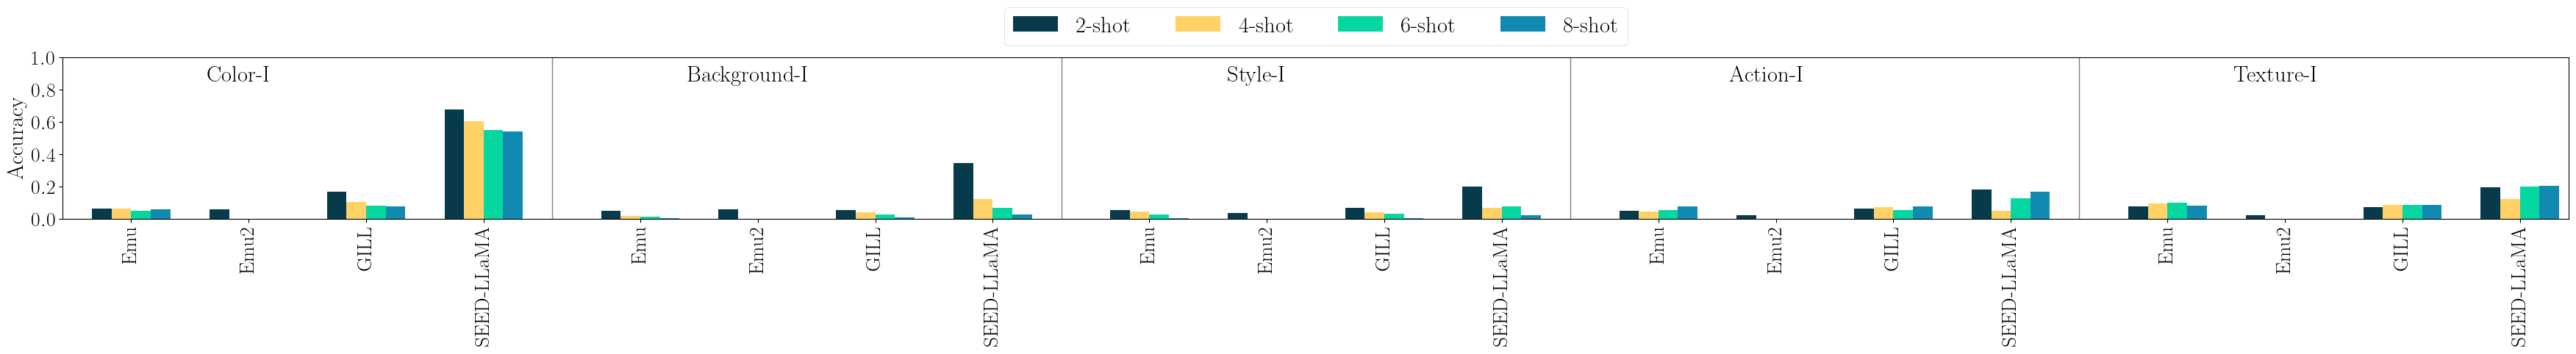

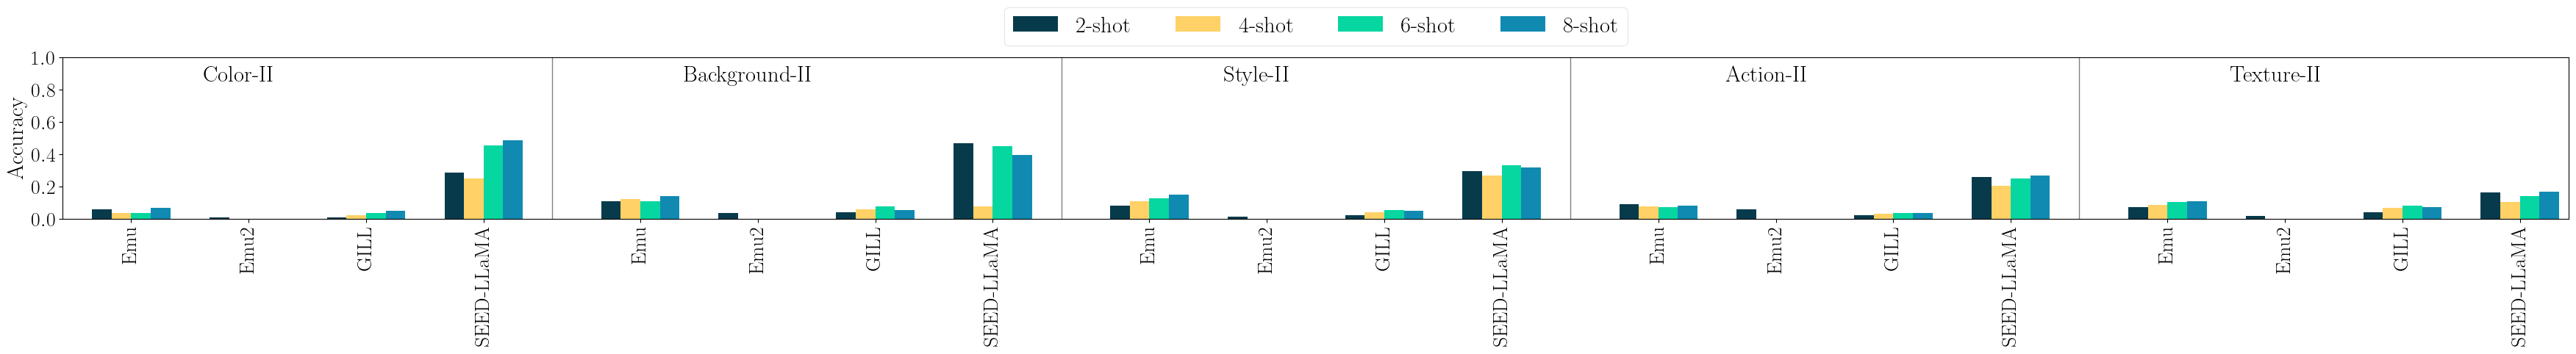

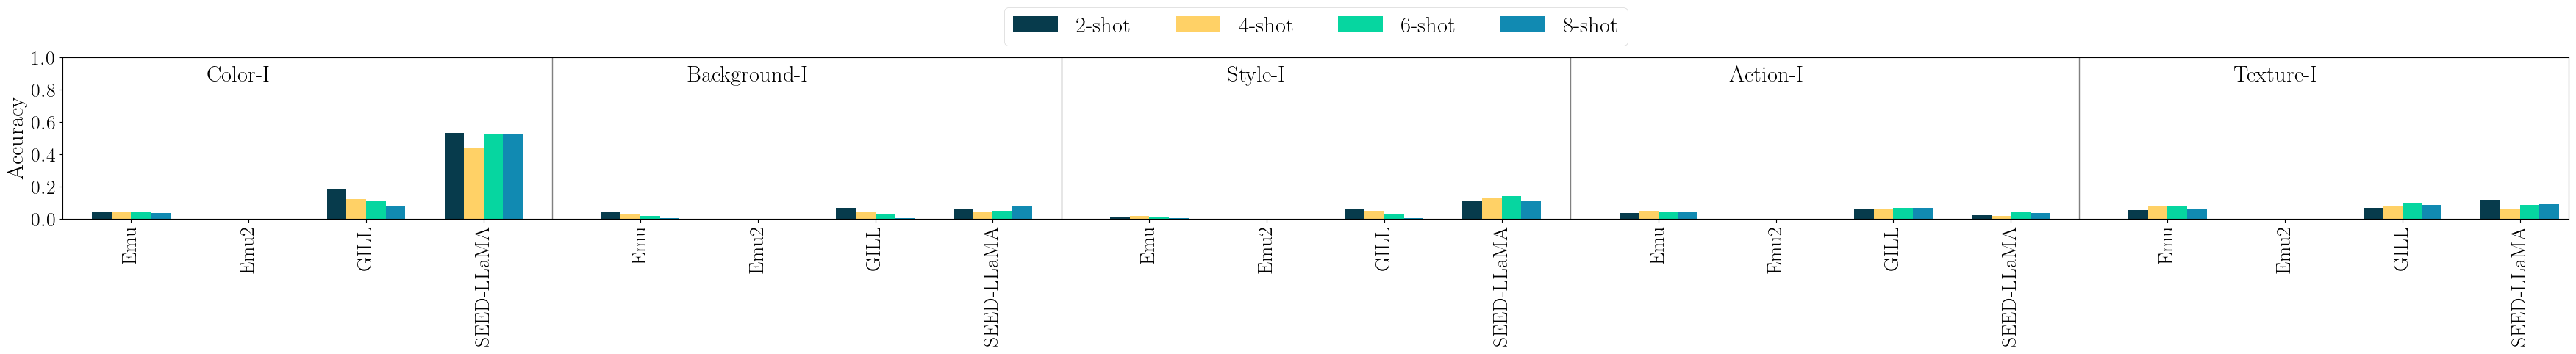

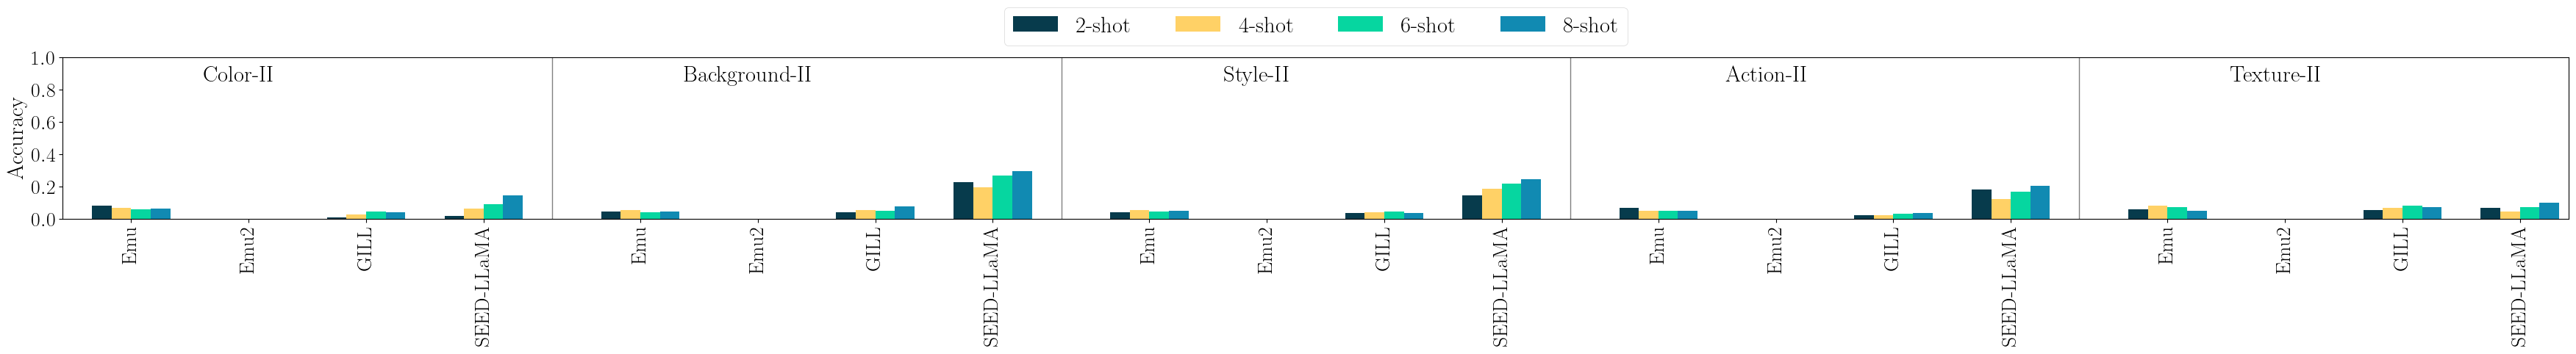

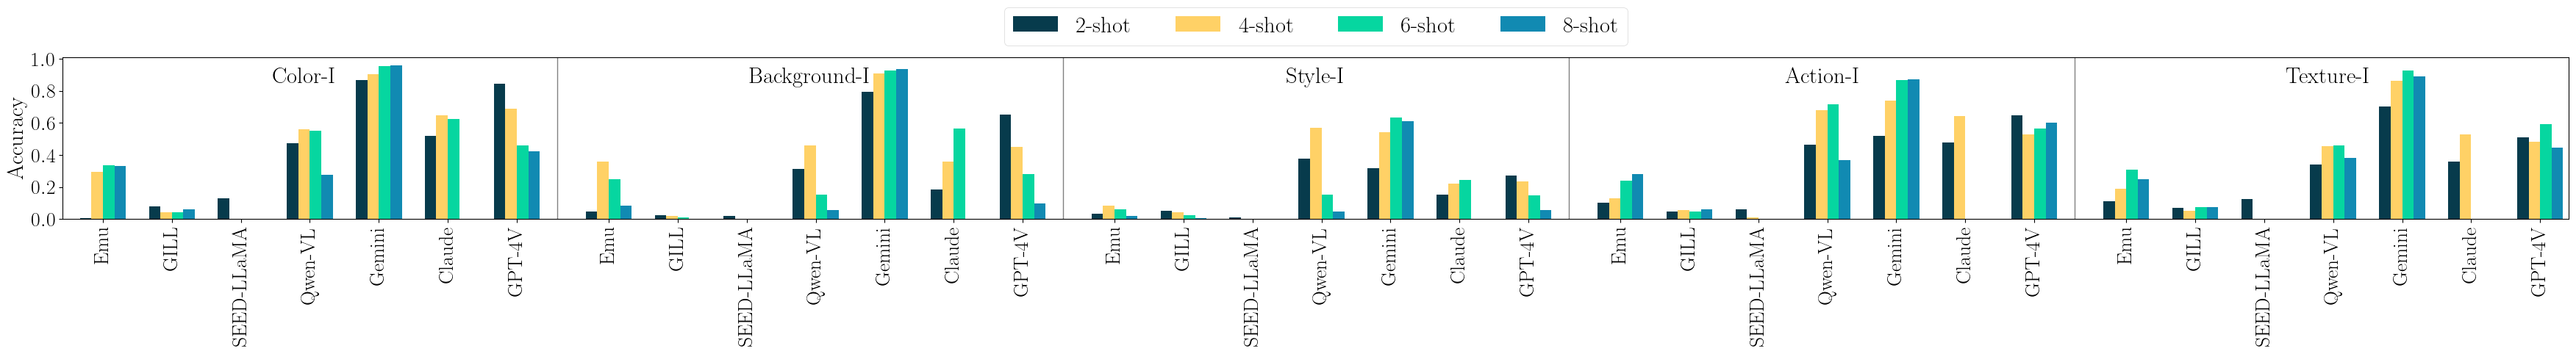

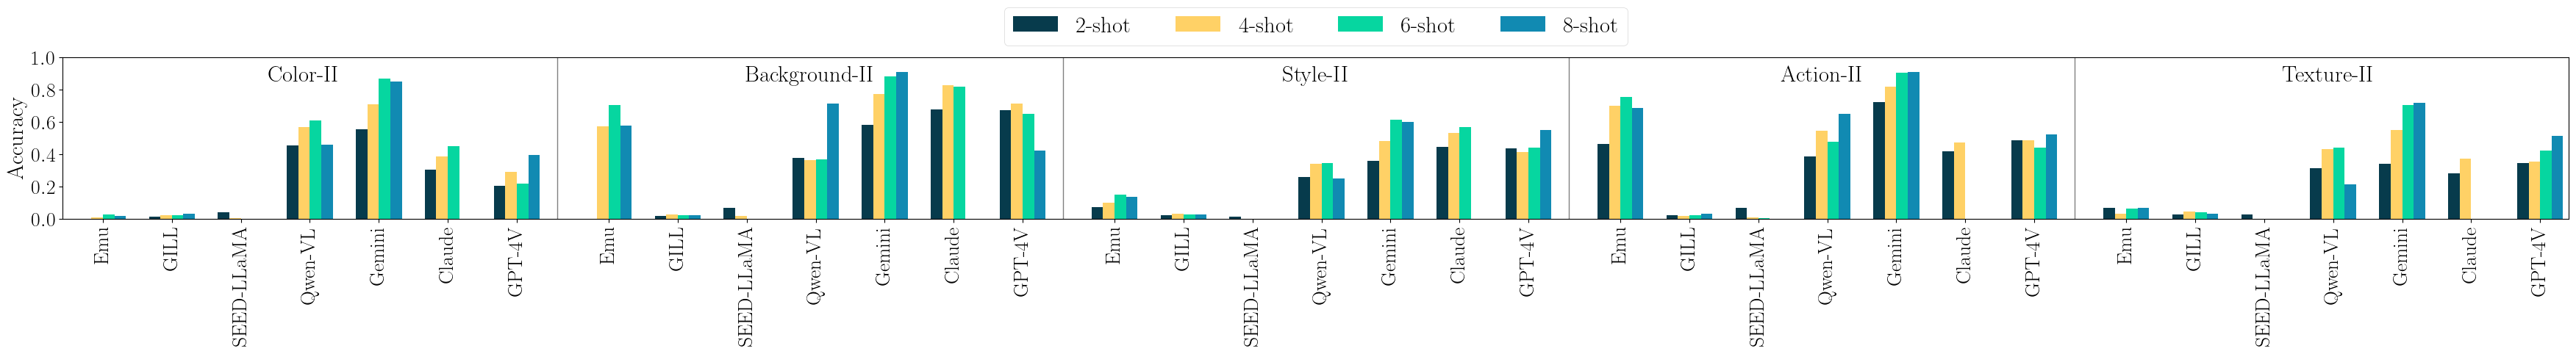

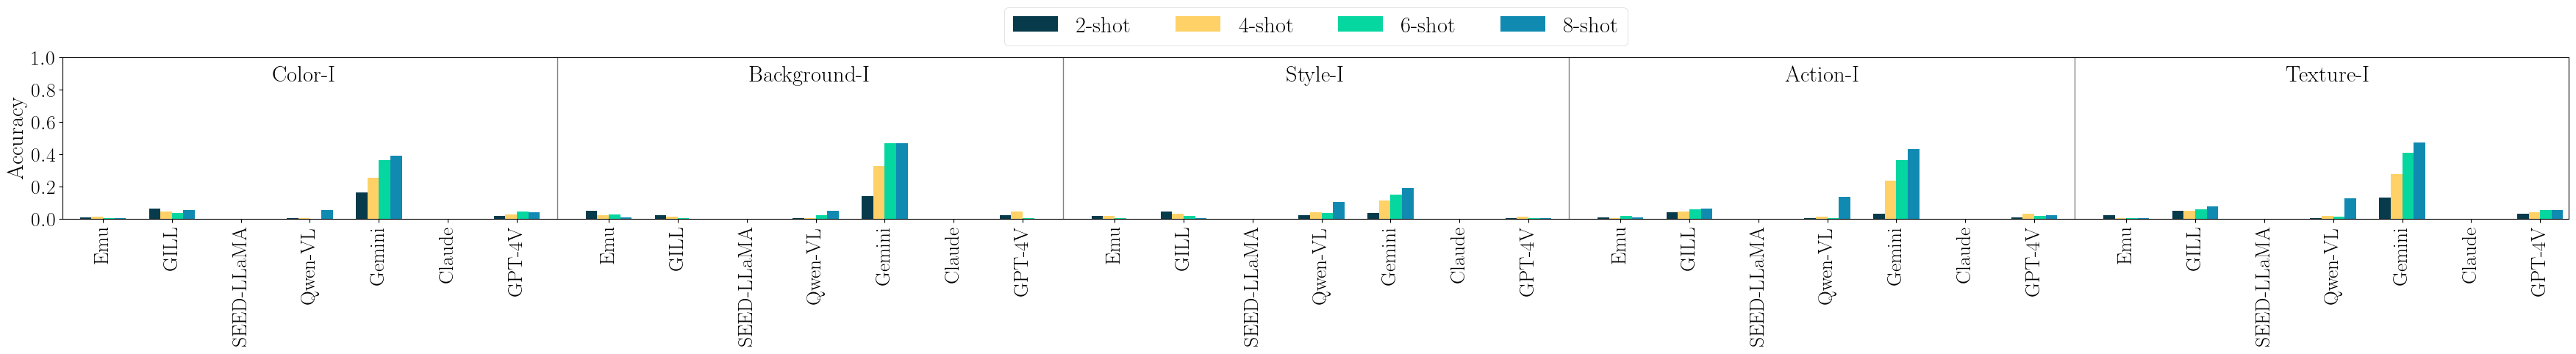

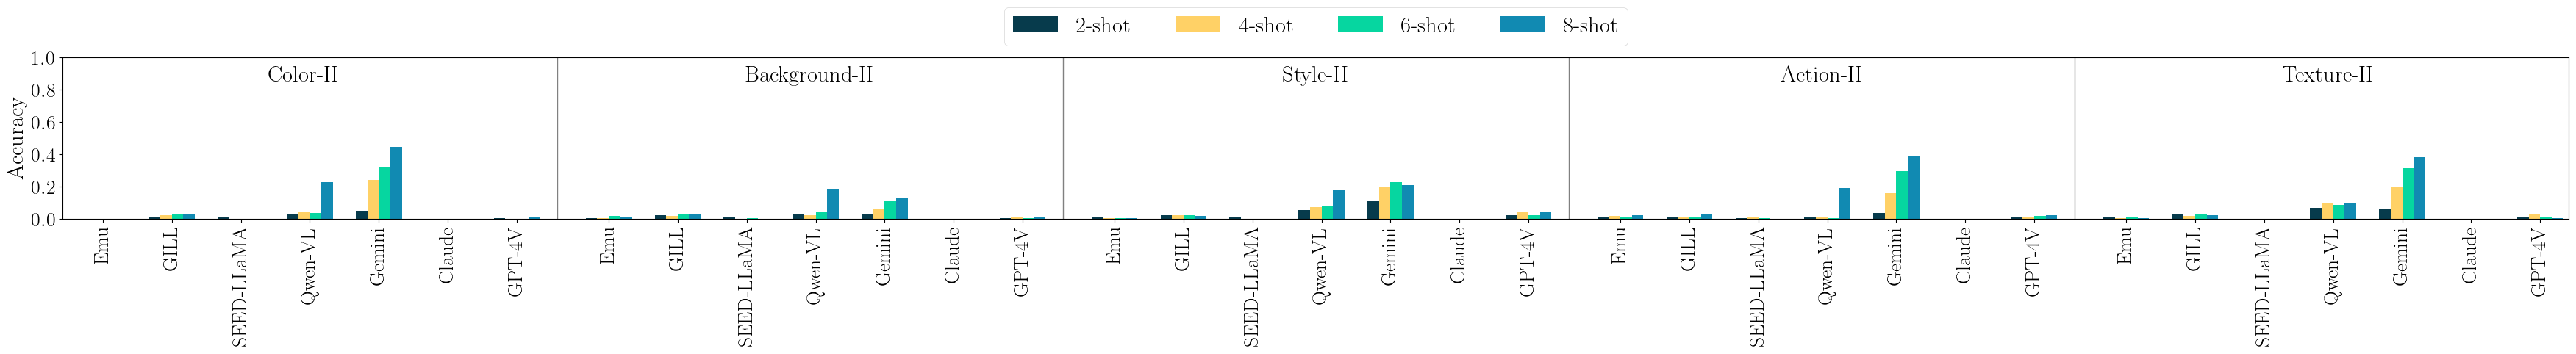

In [19]:
data_mode = 'default'
for model_mode in ['image', 'text']:
    for prompt_type in ['default', 'misleading']:
        for task_inference in ['object', 'detail']:
            bar_width = 2.5
            # ask_inference = task_inference
            # model_mode = model_mode
            width, height = 35, 5
            # prompt_type = prompt_type
            metric = 'overall'
            wspace = 5
            barspace = 15

            r1_data = get_shot_bars(
                num_shot = 2,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


            r2_data = get_shot_bars(
                num_shot = 4,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

            r3_data = get_shot_bars(
                num_shot = 6,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

            r4_data = get_shot_bars(
                num_shot = 8,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


            fig, ax = plt.subplots(nrows = 1, ncols = 1)
            fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
            fig.set_size_inches(width, height) 

            xticks, xticklabels = [], []
            for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
                ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
                ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
                ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
                ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
                xticks.append((v2['position'] + v3['position'])/2)
                xticklabels.append(model_dict[model_mode][v3['model']])
                
                if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
                    ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
                    
                if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
                    if not i // len(model_dict[model_mode]) == 4:
                        ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
                
                # add legend
                if i == 0:
                    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
                    
            ax.set_xticks(xticks)
            ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
            # break the line of the xticklabels
            ax.set_xticklabels(xticklabels, rotation = 90)
            ax.set_yticks(np.arange(0, 1.2, 0.2))
            # set ylabel 
            ax.set_ylabel('Accuracy', fontsize=22)
            save_path = f'{root_dir}/figures/{task_inference}_inference_m_{prompt_type}_{model_mode}.pdf'
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            fig.savefig(save_path)
            plt.show()

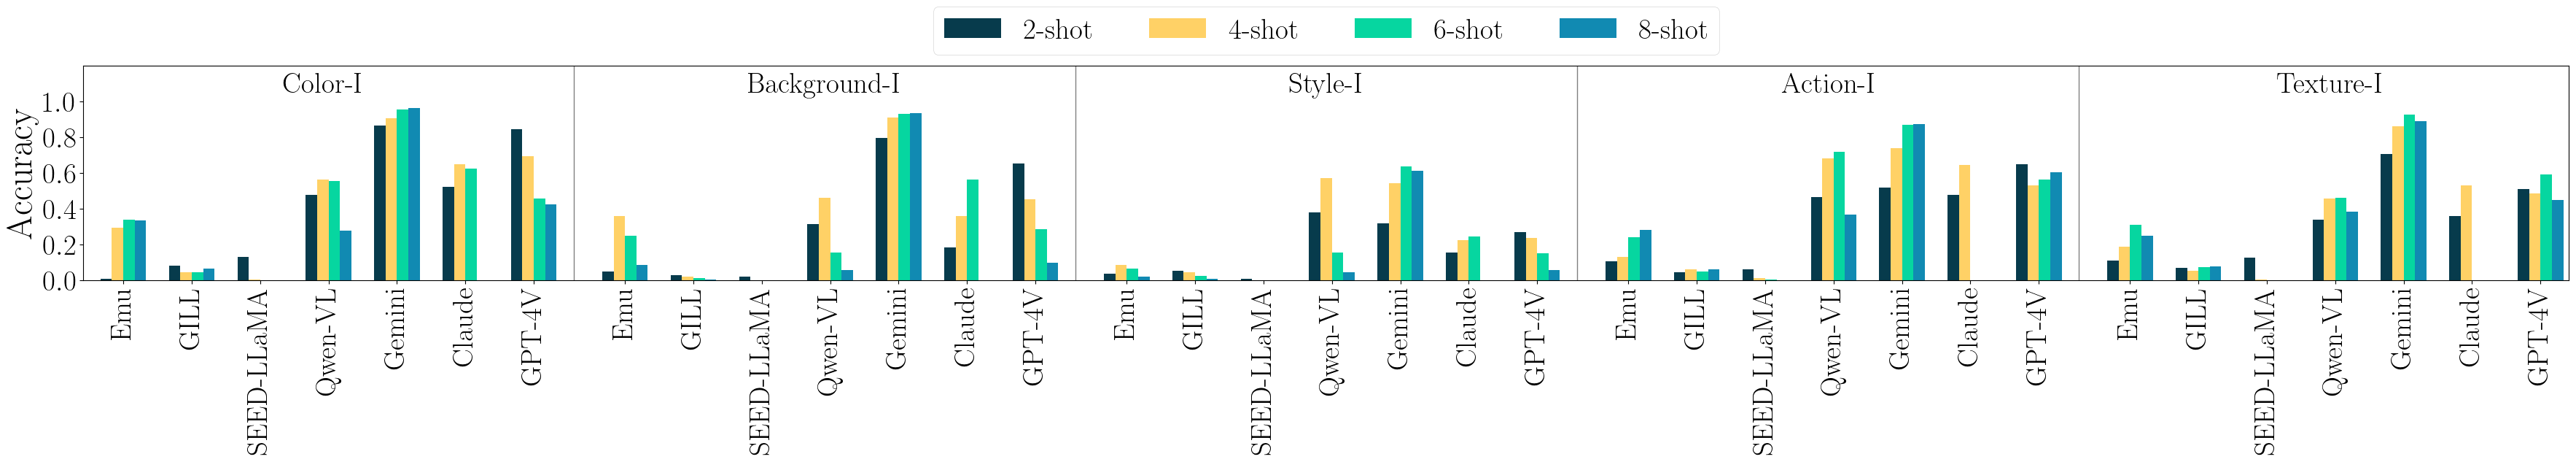

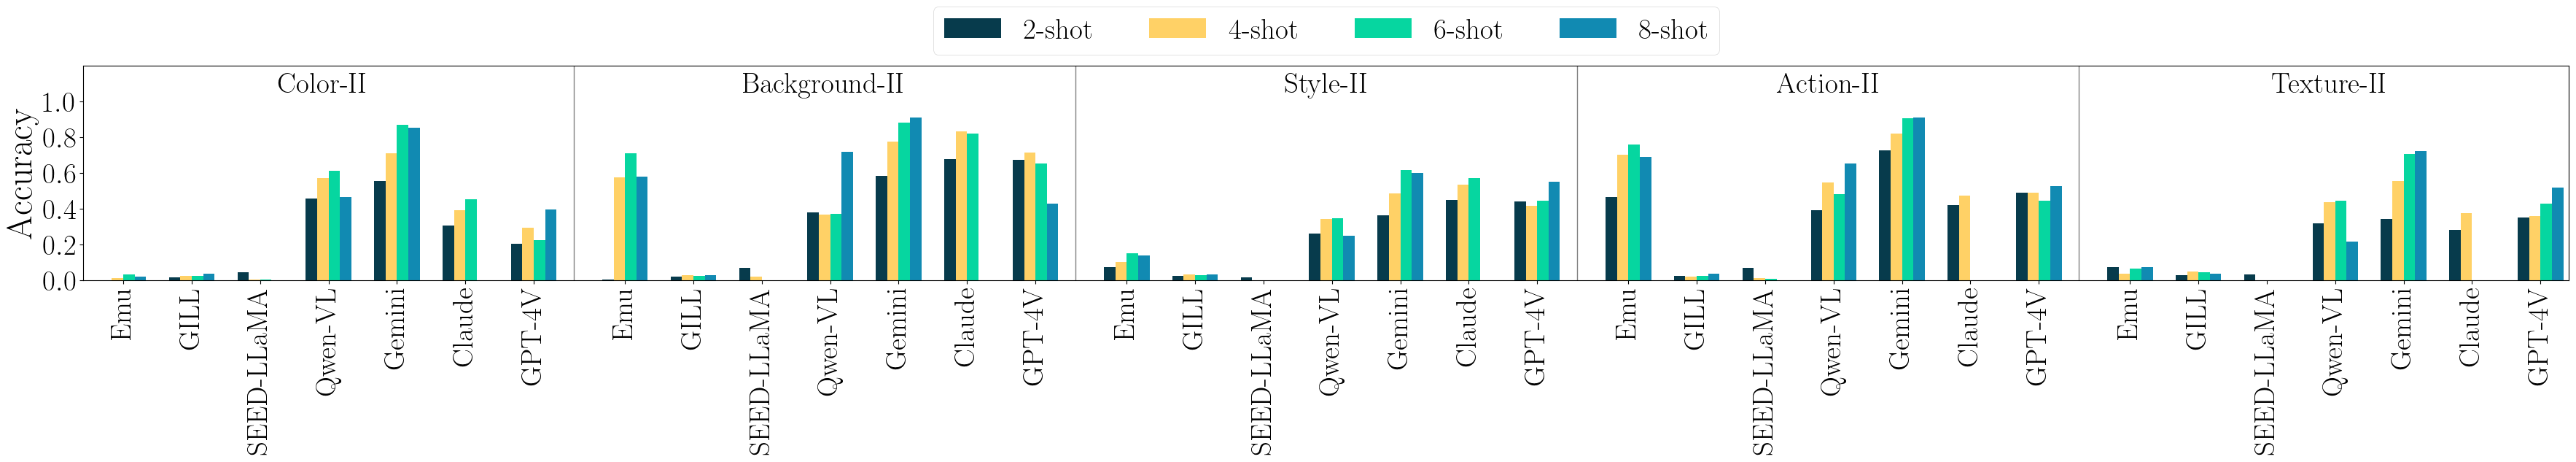

In [40]:
data_mode = 'default'
for model_mode in ['text']:
    for prompt_type in ['default']:
        for task_inference in ['object', 'detail']:
            bar_width = 2.5
            # ask_inference = task_inference
            # model_mode = model_mode
            width, height = 35, 6
            # prompt_type = prompt_type
            metric = 'overall'
            wspace = 5
            barspace = 15

            r1_data = get_shot_bars(
                num_shot = 2,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


            r2_data = get_shot_bars(
                num_shot = 4,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

            r3_data = get_shot_bars(
                num_shot = 6,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

            r4_data = get_shot_bars(
                num_shot = 8,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


            fig, ax = plt.subplots(nrows = 1, ncols = 1)
            fig.subplots_adjust(left=0.025, bottom=.4, right=0.999, top=.89, wspace=0, hspace = 0.3) #margin of the figure
            fig.set_size_inches(width, height) 

            xticks, xticklabels = [], []
            for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
                ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
                ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
                ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
                ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
                xticks.append((v2['position'] + v3['position'])/2)
                xticklabels.append(model_dict[model_mode][v3['model']])
                
                if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
                    ax.text(v2['position'], 1.05, v2['task'], fontsize=28, fontweight='bold', ha='center')
                    
                if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
                    if not i // len(model_dict[model_mode]) == 4:
                        ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
                
                # add legend
                if i == 0:
                    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.34), ncol=4, fontsize=28)
                    
            ax.set_xticks(xticks)
            ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
            # break the line of the xticklabels
            ax.set_xticklabels(xticklabels, rotation = 90, fontsize = 28)
            ax.set_ylim(0, 1.2)
            ax.set_yticks(np.arange(0, 1.2, 0.2))
            # set ylabel 
            ax.set_ylabel('Accuracy', fontsize=35)
            save_path = f'{root_dir}/figures/{task_inference}_inference_m_{prompt_type}_{model_mode}.pdf'
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            fig.savefig(save_path)
            plt.show()

In [36]:
bar_width = 2.5
task_inference = 'object'
model_mode = 'image'
width, height = 35, 5
prompt_type = 0
metric = 'overall'
wspace = 5
barspace = 15

r1_data = get_shot_bars(
    num_shot = 2,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


r2_data = get_shot_bars(
    num_shot = 4,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

r3_data = get_shot_bars(
    num_shot = 6,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

r4_data = get_shot_bars(
    num_shot = 8,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticks, xticklabels = [], []
for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
    ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
    ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
    ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
    ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
    xticks.append((v2['position'] + v3['position'])/2)
    xticklabels.append(model_dict[model_mode][v3['model']])
    
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
        ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
        
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
        if not i // len(model_dict[model_mode]) == 4:
            ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
    
    # add legend
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
        
ax.set_xticks(xticks)
ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
# break the line of the xticklabels
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_yticks(np.arange(0, 1.2, 0.2))
# set ylabel 
ax.set_ylabel('Accuracy', fontsize=22)
save_path = f'{root_dir}/figures/{task_inference}_inference_m_{prompt_type}_{model_mode}.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
fig.savefig(save_path)
plt.show()

TypeError: get_shot_bars() missing 1 required positional argument: 'data_mode'

# Analyze the effect of number of demonstrations

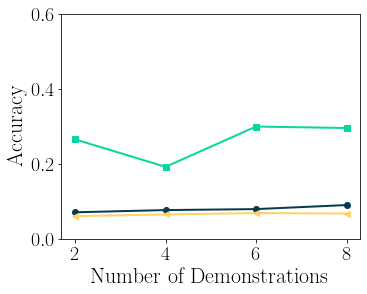

In [12]:
model_mode = 'image'
metric = 'overall'
prompt_type = 0
width, height = 5,4
num_shots = [2,4,6,8]

results = {}
for model in model_dict[model_mode]:
    results[model] = defaultdict(list)
    for shot in num_shots:
        for task_id in task_dataframe:
            results[model][shot].append(get_acc(
                model = model,
                mode = model_mode,
                shot = shot,
                task_id = task_id,
                metric = metric,
                prompt_type = prompt_type,
            ))
        
        results[model][shot] = np.mean(results[model][shot])
results = pd.DataFrame(results)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.16, bottom=.18, right=0.99, top=.96, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

for i, model in enumerate(results):
    results[model].plot(marker = markers[i], color = colors[i], ax = ax, linewidth = 2, label = model_dict[model_mode][model])
ax.set_xticks(num_shots)
ax.set_xticklabels(num_shots)
ax.set_ylim(0,.6)
ax.set_xlabel('Number of Demonstrations', fontsize=22)
ax.set_ylabel('Accuracy', fontsize=22)
# ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=len(model_dict[model_mode]), fontsize=15)

fig.savefig(f'{root_dir}/figures/impact_demos_{model_mode}_{prompt_type}.pdf')
plt.show()

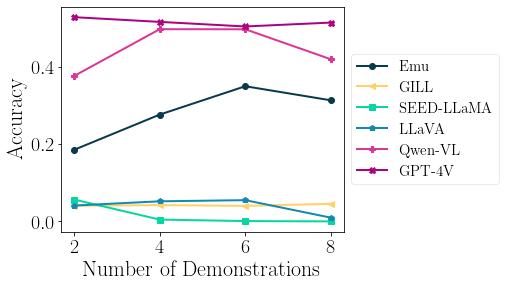

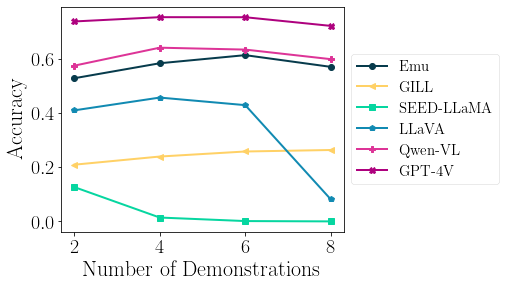

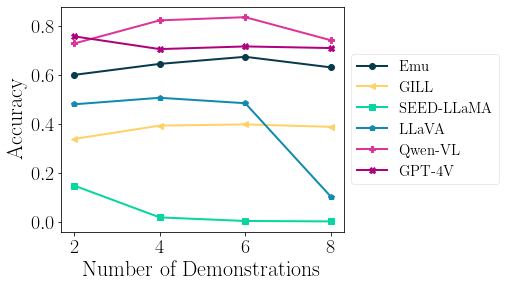

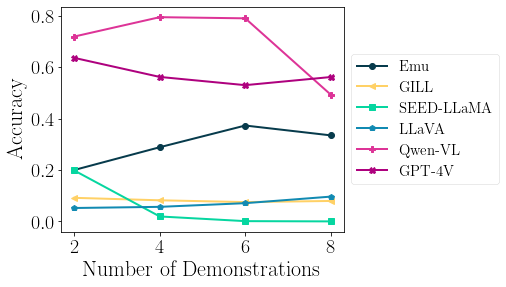

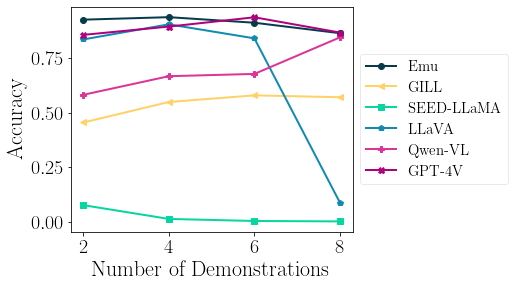

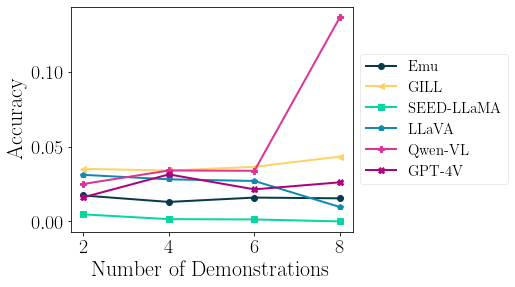

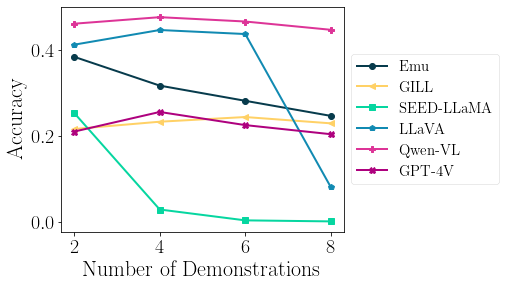

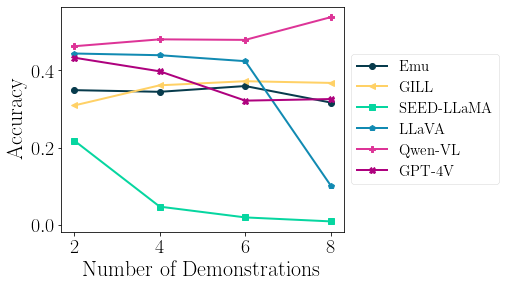

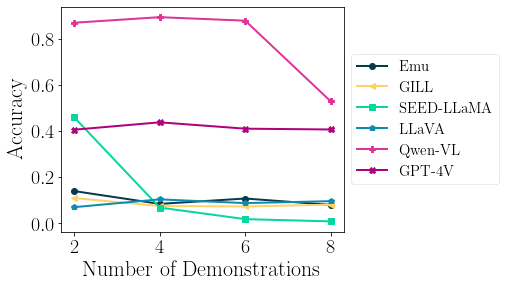

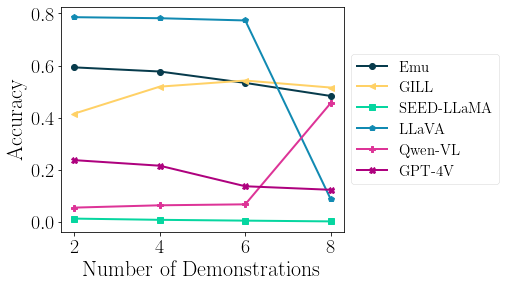

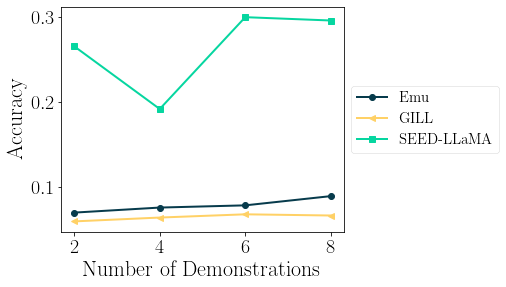

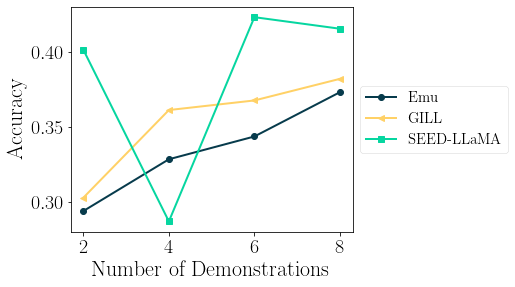

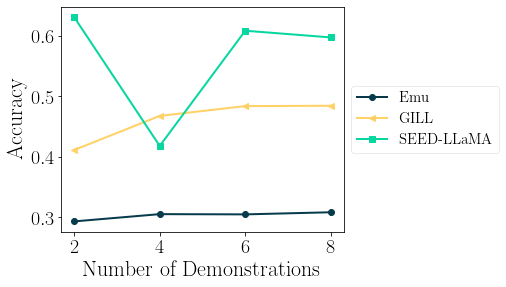

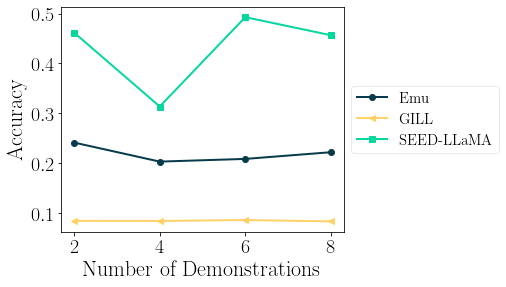

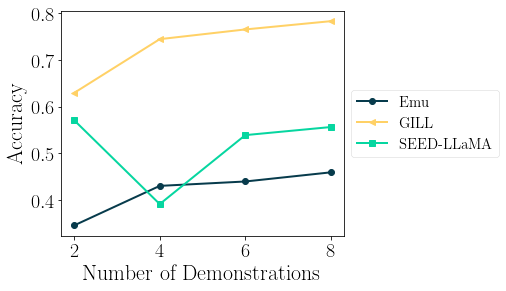

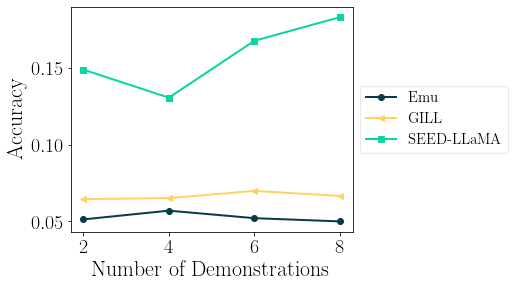

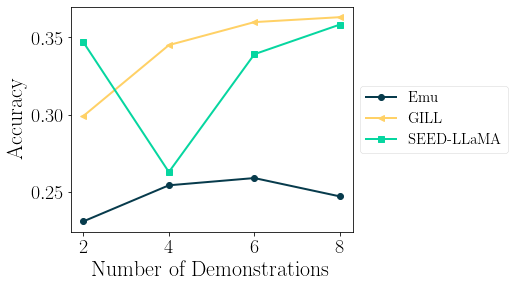

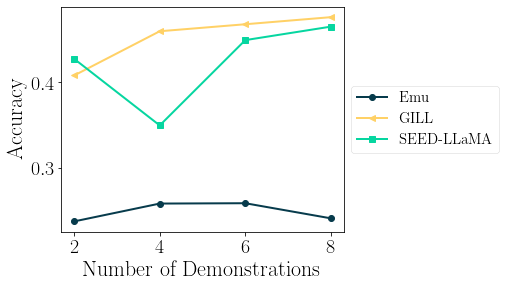

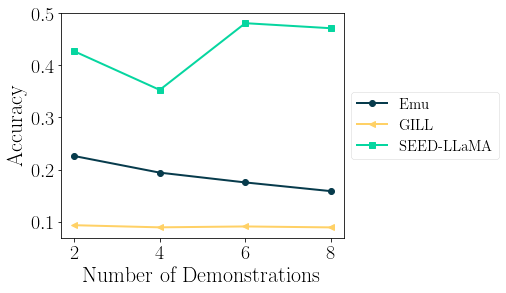

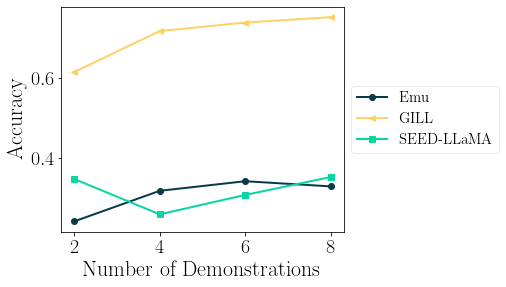

In [13]:
model_mode = 'text'
prompt_type = 0
width, height = 7,4
num_shots = [2,4,6,8]

for model_mode in ['text', 'image']:
    for prompt_type in [0,1]:
        for metric in ['overall', 'detail', 'obj', 'textual', 'visual']:
            results = {}
            for model in model_dict[model_mode]:
                results[model] = defaultdict(list)
                for shot in num_shots:
                    for task_id in task_dataframe:
                        results[model][shot].append(get_acc(
                            model = model,
                            mode = model_mode,
                            shot = shot,
                            task_id = task_id,
                            metric = metric,
                            prompt_type = prompt_type,
                        ))
                    
                    results[model][shot] = np.mean(results[model][shot])
            results = pd.DataFrame(results)

            fig, ax = plt.subplots(nrows = 1, ncols = 1)
            fig.subplots_adjust(left=0.12, bottom=.18, right=0.68, top=.96, wspace=0, hspace = 0.3) #margin of the figure
            fig.set_size_inches(width, height) 

            for i, model in enumerate(results):
                results[model].plot(marker = markers[i], color = colors[i], ax = ax, linewidth = 2, label = model_dict[model_mode][model])
            ax.set_xticks(num_shots)
            ax.set_xticklabels(num_shots)
            ax.set_xlabel('Number of Demonstrations', fontsize=22)
            ax.set_ylabel('Accuracy', fontsize=22)
            # ax.set_ylim(0,.6)
            # reduce the space between the legend and the figure
            ax.legend(loc='center left', bbox_to_anchor=(1, .5), ncol=1, fontsize=15)

            fig.savefig(f'{root_dir}/figures/impact_demos_{model_mode}_{prompt_type}_{metric}.pdf')
            plt.show()

# Object inference v.s. detail inference

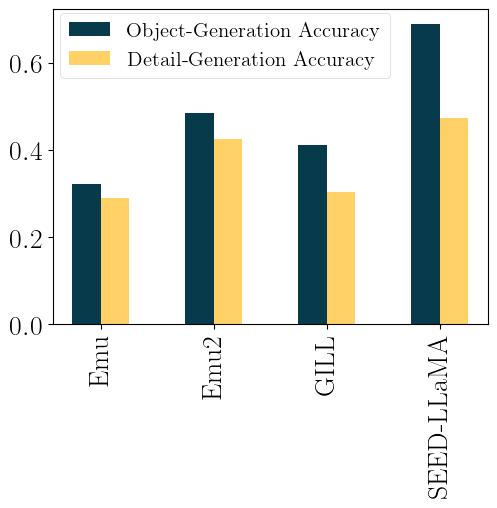

In [60]:
model_mode = 'image'
prompt_type = 'default'
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10
data_mode = 'default'

results = {}
for metric in ['obj', 'detail']:
    results[metric] = {}
    for model in model_dict[model_mode]:
        results[metric][model] = {}
        for shot in [num_shot]:
            results[metric][model][shot] = []
            for task_id in task_dataframe:
                results[metric][model][shot].append(get_acc(
                    model = model,
                    mode = model_mode,
                    shot = shot,
                    task_id = task_id,
                    metric = metric,
                    prompt_type = prompt_type,
                    data_mode = data_mode,
                ))

            results[metric][model][shot] = np.mean(results[metric][model][shot])

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.98, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticklabels = []
for i, model in enumerate(model_dict[model_mode]):
    ax.bar(barspace*i, results['obj'][model][num_shot], width = bar_width, color = colors[0], label = 'Object-Generation Accuracy')
    ax.bar(barspace*i + bar_width, results['detail'][model][num_shot], width = bar_width, color = colors[1], label = 'Detail-Generation Accuracy')
    xticklabels.append(model_dict[model_mode][model])
    
    if i == 0: ax.legend(bbox_to_anchor=(.8, .75), ncol=1, fontsize=15)
    
ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
ax.set_xticklabels(xticklabels, rotation = 90)
fig.savefig(f'{root_dir}/figures/impact_obj_detail_shot_{num_shot}_{model_mode}_{prompt_type}.pdf')
plt.show()

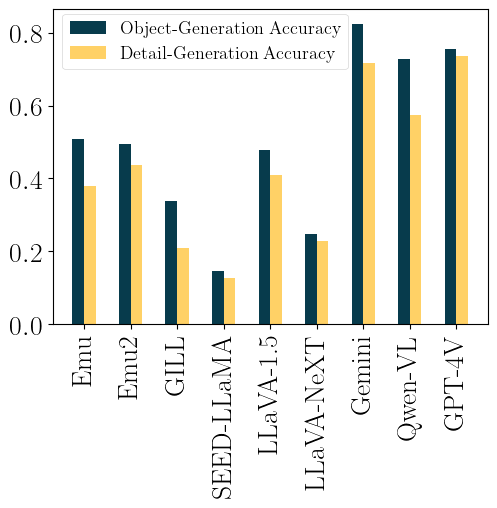

In [68]:
model_mode = 'text'
prompt_type = 'default'
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10
data_mode = 'default'

results = {}
for metric in ['obj', 'detail']:
    results[metric] = {}
    for model in model_dict[model_mode]:
        results[metric][model] = {}
        for shot in [num_shot]:
            results[metric][model][shot] = []
            for task_id in task_dataframe:
                results[metric][model][shot].append(get_acc(
                    model = model,
                    mode = model_mode,
                    shot = shot,
                    task_id = task_id,
                    metric = metric,
                    prompt_type = prompt_type,
                    data_mode = data_mode,
                ))

            results[metric][model][shot] = np.mean(results[metric][model][shot])

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.98, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticklabels = []
for i, model in enumerate(model_dict[model_mode]):
    ax.bar(barspace*i, results['obj'][model][num_shot], width = bar_width, color = colors[0], label = 'Object-Generation Accuracy')
    ax.bar(barspace*i + bar_width, results['detail'][model][num_shot], width = bar_width, color = colors[1], label = 'Detail-Generation Accuracy')
    xticklabels.append(model_dict[model_mode][model])
    
    if i == 0: ax.legend(bbox_to_anchor=(.7, .78), ncol=1, fontsize=13)
    
ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
ax.set_xticklabels(xticklabels, rotation = 90)
fig.savefig(f'{root_dir}/figures/impact_obj_detail_shot_{num_shot}_{model_mode}_{prompt_type}.pdf')
plt.show()

# Textual v.s. Visual

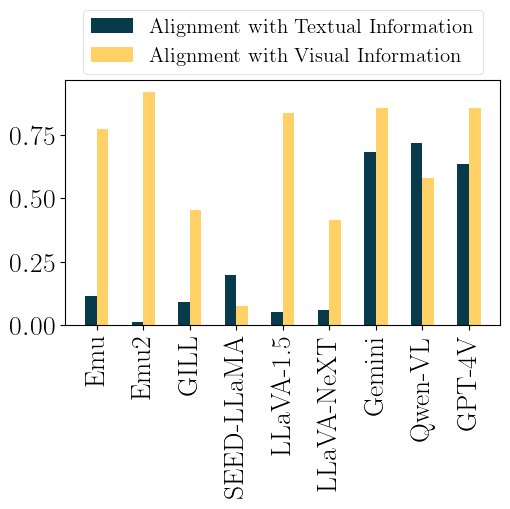

In [70]:
model_mode = 'text'
prompt_type = 'default'
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10
data_mode = 'default'

results = {}
for metric in ['textual', 'visual']:
    results[metric] = {}
    for model in model_dict[model_mode]:
        results[metric][model] = {}
        for shot in num_shots:
            results[metric][model][shot] = []
            for task_id in task_dataframe:
                results[metric][model][shot].append(get_acc(
                    model = model,
                    mode = model_mode,
                    shot = shot,
                    task_id = task_id,
                    metric = metric,
                    prompt_type = prompt_type,
                    data_mode = data_mode,
                ))
            results[metric][model][shot] = np.mean(results[metric][model][shot])

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.84, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticklabels = []
for i, model in enumerate(model_dict[model_mode]):
    ax.bar(barspace*i, results['textual'][model][num_shot], width = bar_width, color = colors[0], label = 'Alignment with Textual Information')
    ax.bar(barspace*i + bar_width, results['visual'][model][num_shot], width = bar_width, color = colors[1], label = 'Alignment with Visual Information')
    xticklabels.append(model_dict[model_mode][model])
    
    if i == 0: ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.33), ncol=1, fontsize=15)
    
ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
ax.set_xticklabels(xticklabels, rotation = 90)
fig.savefig(f'{root_dir}/figures/impact_textual_visual_shot_{num_shot}_{model_mode}_{prompt_type}.pdf')
plt.show()

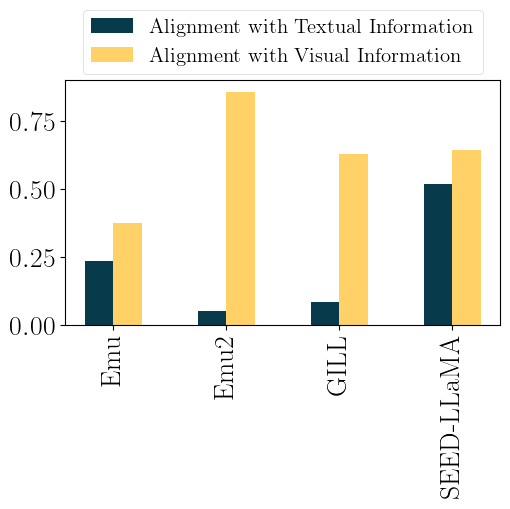

In [71]:
model_mode = 'image'
prompt_type = 'default'
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10
data_mode = 'default'

results = {}
for metric in ['textual', 'visual']:
    results[metric] = {}
    for model in model_dict[model_mode]:
        results[metric][model] = {}
        for shot in num_shots:
            results[metric][model][shot] = []
            for task_id in task_dataframe:
                results[metric][model][shot].append(get_acc(
                    model = model,
                    mode = model_mode,
                    shot = shot,
                    task_id = task_id,
                    metric = metric,
                    prompt_type = prompt_type,
                    data_mode = data_mode,
                ))
            results[metric][model][shot] = np.mean(results[metric][model][shot])

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.84, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticklabels = []
for i, model in enumerate(model_dict[model_mode]):
    ax.bar(barspace*i, results['textual'][model][num_shot], width = bar_width, color = colors[0], label = 'Alignment with Textual Information')
    ax.bar(barspace*i + bar_width, results['visual'][model][num_shot], width = bar_width, color = colors[1], label = 'Alignment with Visual Information')
    xticklabels.append(model_dict[model_mode][model])
    
    if i == 0: ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.33), ncol=1, fontsize=15)
    
ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
ax.set_xticklabels(xticklabels, rotation = 90)
fig.savefig(f'{root_dir}/figures/impact_textual_visual_shot_{num_shot}_{model_mode}_{prompt_type}.pdf')
plt.show()